In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from abc import abstractmethod

In [67]:
OUTPUT_PATH = 'output/'
INPUT_PATH = 'dataset/'
BASE_FILE_NAME='btcusdt'
# TIME_FRAMES=['1h','3m','5m','15m','30m']
TIME_FRAMES=['1h']

SIGNALS = [-1,0,1]
PRICE_TYPE = ['open','close','high','low']

In [68]:
class PrVO:

    def __init__(self,open:float,high:float,low:float,close:float,volume:int,timeStamp:datetime) -> None:
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.timeStamp = timeStamp
        self.returns = (close - open)/open
        self.candle_color = 'GREEN' if self.close > self.open else 'RED'

    def __repr__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
    def __str__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    

class Trade:
    
    def __init__(self) -> None:
        self.timeStamp = None
        self.signal = None
        self.price_type = None
    
    def execute(self,PrVo:PrVO ,signal:int,price_type:str) -> object:
        
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"

        self.PrVo = PrVo
        self.signal = signal
        self.price_type = price_type
        return self
    
    def __str__(self) -> str:
        return f"{self.PrVo}\t{self.signal}\t {self.price_type}"
    

In [69]:
class TradingTerminal:

    def __init__(self) -> None:
        self.time=None
        self.PrVo=dict()
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_penalty=0.001
        self.transaction_cost=0

        for timeframe in TIME_FRAMES:
            self.readData(BASE_FILE_NAME+'_'+timeframe+'.xlsx')

    def readData(self,filepath):
        df=pd.read_excel(INPUT_PATH+filepath)
        
        data=[]
        for index,row in df.iterrows():
            data.append(PrVO(row['open'],row['high'],row['low'],row['close'],row['volume'],row['datetime']))

        data_timeframe=filepath.split('/')[-1].split('.')[0].split('_')[1]
        self.PrVo[data_timeframe]=np.array(data)
        
    def takeTrade(self,PrVo,signal,price_type):
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"

        trade=Trade().execute(PrVo,signal,price_type)
        self.tradeHistory.append(trade)

    def outputTradeHistory(self):
        file=open(OUTPUT_PATH+'trade_history.txt','w')

        file.write(f"Index,timestamp,signals,open,high,low,close,volume\n")
        
        for index,trade in enumerate(self.tradeHistory):
            file.write(f"{index},{trade.PrVo.timeStamp},{trade.signal},{trade.PrVo.open},{trade.PrVo.high},{trade.PrVo.low},{trade.PrVo.close},{trade.PrVo.volume}\n")

    def setTime(self,time):
        self.time=time

    def resetEverything(self):
        self.time=None
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_penalty=0.001
        self.transaction_cost=0

    def getSimpleMovingAverage(self, lag, timeframe, price_type):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"
        
        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = np.convolve(prices, np.ones(lag) / lag, mode='valid')
        sma = np.concatenate([np.full(lag - 1, np.nan), sma])
        return sma

    def getExponentialMovingAverage(self, span, timeframe, price_type):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        ema = pd.Series(prices).ewm(span=span, adjust=False).mean().values
        return ema

    def getBollingerBands(self, lag, std_dev_factor, timeframe, price_type):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = self.getSimpleMovingAverage(lag, timeframe, price_type)
        
        rolling_std = pd.Series(prices).rolling(window=lag).std().values

        upper_band = sma + std_dev_factor * rolling_std
        lower_band = sma - std_dev_factor * rolling_std

        return upper_band, sma, lower_band

    def calculateATR(self, period, timeframe, price_type):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])

        high = np.array([entry['high'] for entry in self.PrVo[timeframe]])
        low = np.array([entry['low'] for entry in self.PrVo[timeframe]])

        tr = np.maximum(np.maximum(high - low, np.abs(high - prices[1:])), np.abs(low - prices[1:]))

        atr = np.zeros_like(prices)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(prices)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def calculateSuperTrend(self, period, multiplier, timeframe, price_type):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        atr = self.calculateATR(period, timeframe, price_type)

        upper_band = prices + multiplier * atr
        lower_band = prices - multiplier * atr

        uptrend = True
        supertrend = np.zeros_like(prices)

        for i in range(period, len(prices)):
            if prices[i] > upper_band[i - 1] and uptrend:
                supertrend[i] = lower_band[i]
                uptrend = False
            elif prices[i] < lower_band[i - 1] and not uptrend:
                supertrend[i] = upper_band[i]
                uptrend = True
            else:
                supertrend[i] = supertrend[i - 1] if uptrend else supertrend[i - 1]

        return supertrend
    
    def calculateRSI(self, period, timeframe, price_type):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])

        # Calculate daily price changes
        price_changes = np.diff(prices)

        # Calculate gains (positive changes) and losses (negative changes)
        gains = np.where(price_changes > 0, price_changes, 0)
        losses = np.where(price_changes < 0, -price_changes, 0)

        # Calculate average gains and losses over the specified period
        avg_gain = np.mean(gains[:period])
        avg_loss = np.mean(losses[:period])

        rsi_values = np.zeros_like(prices)

        # Calculate RSI for each day after the initial period
        for i in range(period, len(prices)):
            gain = gains[i - 1] if price_changes[i - 1] > 0 else 0
            loss = losses[i - 1] if price_changes[i - 1] < 0 else 0

            avg_gain = (avg_gain * (period - 1) + gain) / period
            avg_loss = (avg_loss * (period - 1) + loss) / period

            rs = avg_gain / avg_loss if avg_loss != 0 else np.inf
            rsi_values[i] = 100 - (100 / (1 + rs))

        return rsi_values

    def calculateMACD(self, short_window, long_window, signal_window, timeframe, price_type):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])

        # Calculate short-term EMA
        short_ema = pd.Series(prices).ewm(span=short_window, adjust=False).mean()

        # Calculate long-term EMA
        long_ema = pd.Series(prices).ewm(span=long_window, adjust=False).mean()

        # Calculate MACD line
        macd_line = short_ema - long_ema

        # Calculate signal line
        signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

        # Calculate MACD histogram
        macd_histogram = macd_line - signal_line

        return macd_line.values, signal_line.values, macd_histogram.values

    def calculateADX(self, period, timeframe):
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        high = np.array([entry['high'] for entry in self.PrVo[timeframe]])
        low = np.array([entry['low'] for entry in self.PrVo[timeframe]])
        close = np.array([entry['close'] for entry in self.PrVo[timeframe]])

        # True Range Calculation
        tr = np.maximum.reduce([high[1:] - low[1:], np.abs(high[1:] - close[:-1]), np.abs(low[1:] - close[:-1])])

        # Positive Directional Movement
        pos_dm = np.where(high[1:] - high[:-1] > low[:-1] - low[1:], np.maximum(high[1:] - high[:-1], 0), 0)

        # Negative Directional Movement
        neg_dm = np.where(low[:-1] - low[1:] > high[1:] - high[:-1], np.maximum(low[:-1] - low[1:], 0), 0)

        # Smoothed True Range, Positive Directional Movement, and Negative Directional Movement
        atr = pd.Series(tr).ewm(span=period, adjust=False).mean().values
        pos_dm_smoothed = pd.Series(pos_dm).ewm(span=period, adjust=False).mean().values
        neg_dm_smoothed = pd.Series(neg_dm).ewm(span=period, adjust=False).mean().values

        # Positive Directional Index (DI+)
        di_plus = (pos_dm_smoothed / atr) * 100

        # Negative Directional Index (DI-)
        di_minus = (neg_dm_smoothed / atr) * 100

        # Directional Movement Index (DX)
        dx = np.abs((di_plus - di_minus) / (di_plus + di_minus)) * 100

        # Average Directional Index (ADX)
        adx = pd.Series(dx).ewm(span=period, adjust=False).mean().values

        return di_plus, di_minus, adx

    def getPNL(self):

        equity_curve = np.array([self.cash_balance])

        coins_held=0
        
        for trade in self.tradeHistory:
            if trade.signal == 1:
                coins_held=(self.cash_balance*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.cash_balance*(self.transaction_penalty)
                self.cash_balance=0
            elif trade.signal == -1:
                self.cash_balance=(1-self.transaction_penalty)*coins_held*getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.transaction_penalty*coins_held*getattr(trade.PrVo,trade.price_type)
                coins_held=0

            equity_curve=np.append(equity_curve,self.cash_balance+coins_held*getattr(trade.PrVo,trade.price_type))
        
        print(f"Final Cash Balance : {self.cash_balance}")
        print("Transaction Cost : ",self.transaction_cost)
        self.graphEquityCurve(equity_curve)

    def graphEquityCurve(self,equity_curve):
        print("Trades Taken : ",len(equity_curve))
        plt.plot(equity_curve)
        plt.show()


In [70]:
class Strategy:
    def __init__(self,TradingTerminal) -> None:
        self.terminal=TradingTerminal

    @abstractmethod
    def run(self, *args):
        pass

In [71]:
class Strategy1(Strategy):

    def __init__(self,TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self,lag1,lag2,price_type,timeframe):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert lag1>lag2, f"Invalid Lag {lag1} {lag2}"
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()
        PrVo=self.terminal.PrVo[timeframe]

        ema1=self.terminal.getSimpleMovingAverage(lag1,timeframe,price_type)
        ema2=self.terminal.getSimpleMovingAverage(lag2,timeframe,price_type)
        has_purchased = False
                
        for idx, (val1, val2) in enumerate(zip(ema1, ema2)):
            if val1 > val2 and not has_purchased:
                self.terminal.takeTrade(PrVo[idx], 1, price_type)
                has_purchased = True
            elif val2 > val1 and has_purchased:
                self.terminal.takeTrade(PrVo[idx], -1, price_type)
                has_purchased = False        

In [72]:
tt=TradingTerminal()

Final Cash Balance : 75.79717020953757
Transaction Cost :  1398.2275706263213
Trades Taken :  4269


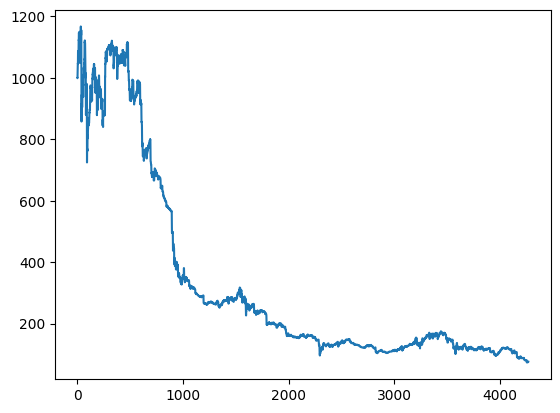

In [73]:
s1=Strategy1(tt)
s1.run(10,5,'open','1h')
tt.outputTradeHistory()
tt.getPNL()